# k-NN implementation

## What is k-NN?
 
As the name suggest **k-NN** makes use of the k nearest neighbours for prediction. k-NN makes use of the labeled training and finds k nearest/similar neighbours to the test point.  The prediction attribute of the most similar data points is summarized and returned as the prediction for the test data.<br>

The kNN algorithm belongs to the family of **instance-based**, **competitive learning** , **supervised**, **lazy learning algorithms**, and **non-parametric**. <br>

**Instance-based**: k-NN is an extreme form of instance-based method as it makes use of all training observations to predict. <br>
**Competitive learning**: It internally uses competition between model elements(data instances), such as most similar or closest instance, in order to make a predictive decision. <br>
**Supervised**: It makes use of labeled training data to make prediction. <br>
**Lazy learning**: Refers to the fact that the algorithm does not build a model until the time that a prediction is required. It is lazy because it only does work at the last second. <br>

Finally, kNN is powerful because it does not assume anything about the data, other than a distance measure can be calculated consistently between any two instances. As such, it is called **non-parametric or non-linear** as it does not assume a functional form.

## Modelling steps for k-NN

1. Have labeled data
2. Select similarity/distance Metric
3. Data pre-processing
3. Pick k
4. Get new sample to classify
5. Select the k entries that are closest/similar to the new sample
6. Take a simple majority/Average/Weighted Average vote to get final prediction

We will use [iris](https://archive.ics.uci.edu/ml/datasets/iris) datasets for **classification** and [boston housing price](https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html) dataset for **regression** using knn. <br><br>
*Note: We will only code the algorithm form scratch but will make use of various python libraries for data handling and interpretations*


In [1]:
# Installing basic libraries we will need
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import operator
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from collections import  Counter
import timeit
from sklearn.neighbors import KNeighborsRegressor

import warnings
warnings.filterwarnings('ignore')

palette = "Dark2"
%matplotlib inline

### 1. Have Labeled data

In [2]:
# Load data
iris_sns = sns.load_dataset("iris")
iris_sns.head(3)

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa


In [3]:
# Split the data into train and test
from sklearn.model_selection import train_test_split
X = np.array(iris_sns.iloc[:,:-1])
y = np.array(iris_sns.iloc[:,-1])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### 2. Select similarity/distance metric

**Distance Metrics**
1. [Euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance)
2. [Hamming distance](https://en.wikipedia.org/wiki/Hamming_distance)
4. [Manhattan](https://en.wikipedia.org/wiki/Taxicab_geometry)
5. [Minkowski](https://en.wikipedia.org/wiki/Minkowski_distance)
5. [Mahalanobis distance](https://en.wikipedia.org/wiki/Mahalanobis_distance)

**Similarity Metrics**
1. [Cosine Similarity](https://en.wikipedia.org/wiki/Cosine_similarity)
2. [Jaccard Index](https://en.wikipedia.org/wiki/Jaccard_index)
3. [Pearson Correlation Coefficient](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient)
4. [KL Divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence)

<br>There are a large number of distance/similarity metrics available and selection of right metric is governed by **problem at hand and domanin knowledge**. I will not discuss all of above metric in this notebook but will create a new notebook for these metrics and their comparisons. For current problem we will go ahead with **Euclidean distance** as our distance metric. Let's define a function for our distance metric


In [4]:
def eculidean_distance(point1,point2):
    if len(point1) != len(point2) :
        raise ValueError('feature length not matching')
    else:
        return np.sqrt(np.sum((np.array(point1) - np.array(point2))**2))

### 3. Data Pre-processing
Based on the similarity/distance metrics, we need to standardize/normalize our data so that no single feature influences the distance a lot. We can either use **Normalization** which scales features between 0 and 1 or **Standardization** so that we have a mean of 0 and standard deviation of 1. For this notebook we will use **MinMaxScale**  for sklearn.

In [5]:
scale = MinMaxScaler()
X_train = scale.fit_transform(X_train)
X_test = scale.transform(X_test)

Note that we use `fit_transform()` for `X_train` but only `transform()` for `X_test` as we want to use same scale transformation for both train and test which is derived based on train data 

### 4. k nearest neighbours
For knn to work, we need the ability to find k nearest neighbours. Let's define a function which does this.

In [6]:
def get_neighbors(train_set_data_points, test_feature_data_point, k):
    
    # Calculate the distances and store in distances
    distances = []
    for index in range(len(train_set_data_points)):
        dist = euclidean_distance(test_feature_data_point, train_set_data_points[index])
        distances.append((train_set_data_points[index], dist, index))
        
    # Sorting the distances in ascending order
    distances.sort(key=operator.itemgetter(1))
    
    # Select k neighbours
    neighbors = []
    for index in range(k):
        neighbors.append(distances[index][2])
    return neighbors

*Note: If you decide to use a different distance/similarity metrics, just change the logic in above function.* <br> <br> **We can also vectorize and merge the distance calculation and selecting k neighbours in a single function**

In [7]:
def get_neighbors_optimized(train_set, test_set, k):

    # calculate euclidean distance
    euc_distance = np.sqrt(np.sum((train_set - test_set)**2 , axis=1))
    # return the index of nearest neighbour
    return np.argsort(euc_distance)[0:k]

### 5. Predictiction

The method of prediction depends on the problem and there are various ways in which we can make predictions. Since we have a classification problem, we will use majority voting as our prediction function. We will also define a mean function for regression.

In [8]:
def predict_classifier(train_set, train_label, test_set, k):
        
        # get the index of all nearest neighbouring data points
        nearest_data_point_index = get_neighbors_optimized(train_set, test_set, k)
        
        # Majority voting
        nearest_data_point_labels = train_label[nearest_data_point_index]
        vote_counts = Counter(nearest_data_point_labels)
        
        # return the class that has most votes
        return max(vote_counts, key=lambda k: vote_counts[k])

In [9]:
def predict_regressor(train_set, train_label, test_set, k):
        
        # get the index of all nearest neighbouring data points
        nearest_data_point_index = get_neighbors_optimized(train_set, test_set, k)
        
        # Mean across all neighbours
        nearest_data_point_labels = train_label[nearest_data_point_index]
        return np.mean(nearest_data_point_labels)

**Note: If you decide to use a different way of calculating the final prediction, juts update the function's above with new logic** <br><br> Let's define few performance metrics so we can evaluate how well our model is performing.
### Evaluation Metrics
We will define **RMSE** and **Accuracy** as our metrics for this notebook.

In [10]:
def get_rmse(y, y_pred):
    mse = np.mean((y - y_pred)**2)
    return round(np.sqrt(mse), 4)

def get_accuracy(y, y_pred):
    cnt = np.equal(y,y_pred).sum()
    return round(cnt/len(y), 2)

### Creating a new class for kNN
For ease of use and standardization, lets define a class with all the relevant functions.

In [11]:
class Knn():
    def __init__(self, k, weights=None):
        self.k = k
        self.weights = weights

    def get_neighbors_optimized(self, train_set, test_set, k):
        euc_distance = np.sqrt(np.sum((train_set - test_set)**2 , axis=1))
        # return the index of nearest neighbour
        return np.argsort(euc_distance)[0:k]
    
    def fit(self, train_feature, train_label):
        self.train_feature = train_feature
        self.train_label = train_label


In [12]:
class KnnClassifier(Knn):

    def predict(self, test_feature_data_point):
        # get the index of all nearest neighbouring data points
        pred = []
        for i in range(len(test_feature_data_point)):
            nearest_point_index = self.get_neighbors_optimized(self.train_feature, test_feature_data_point[i]\
                                                               , self.k)
        
            # Majority voting
            nearest_point_labels = self.train_label[nearest_point_index]
            vote_counts = Counter(nearest_point_labels)
        
            # return the class that has most votes
            pred.append(max(vote_counts, key=lambda k: vote_counts[k]))
        return np.array(pred)

In [13]:
class KnnRegression(Knn):

    def predict(self, test_feature_data_point):
        pred = []
        for i in range(len(test_feature_data_point)):
            nearest_point_index = self.get_neighbors_optimized(self.train_feature,\
                                                               test_feature_data_point[i], self.k)
        
            # Mean across all neighbours
            nearest_point_labels = self.train_label[nearest_point_index]
            pred.append(np.mean(nearest_point_labels))
        return np.array(pred)

### 6.Tunning k value and predicting with new kNN class

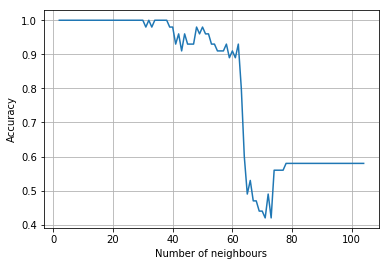

In [14]:
knn_iris_acc = []
for k in range(2, len(X_train)):
    clf = KnnClassifier(k)
    clf.fit(X_train, y_train)
    iris_target_pred = clf.predict(X_test)
    knn_iris_acc.append(get_accuracy(iris_target_pred, y_test))

plt.plot(range(2,len(X_train)), knn_iris_acc)
plt.xlabel('Number of neighbours')
plt.ylabel('Accuracy')
plt.grid()
plt.show()

The plot of the accuracy vs K value gives us information regarding which k gives the best performance, In our case `k=2 to 30` or so gives `accuracy` as `1`. So, we can go with **lowest** `k=2` to reduce computational cost. Also we should get best k value on validation set. We have used our test set as validation set in above example. Lets explore a regression example as well.

### Impact of k on decision boundry

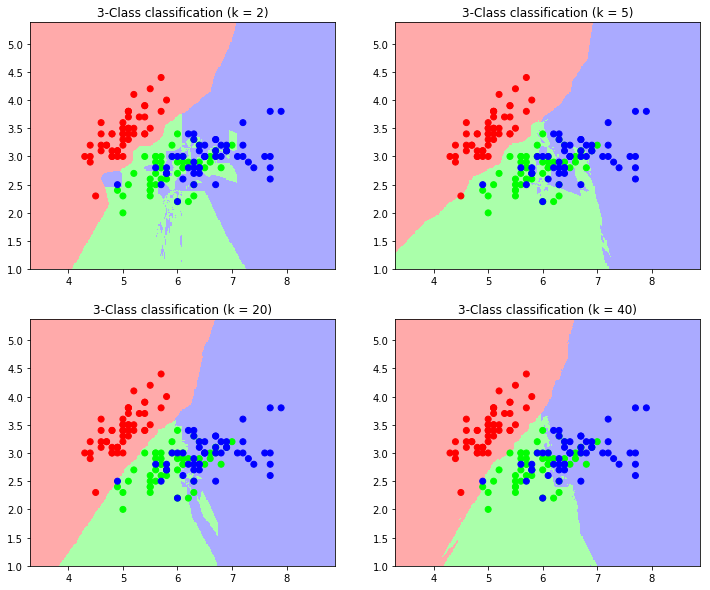

In [15]:
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets

n_neighbors = [2, 5, 20, 40]

# import some data to play with
iris = datasets.load_iris()
X_train = iris.data[:, :2]
y_train = iris.target


h = .02  # step size in the mesh

# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

plt.figure(figsize=(12,10))

for i,k in enumerate(n_neighbors):
    # we create an instance of Neighbours Classifier and fit the data.
    clf = KnnClassifier(k)
    clf.fit(X_train, y_train)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.subplot(221+i)
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot also the training points
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cmap_bold)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("3-Class classification (k = %i)"
              % (k))

plt.show()

**From above figure we can see that, as k increases, the decision boundary becomes smoother.**

### Regression with knn

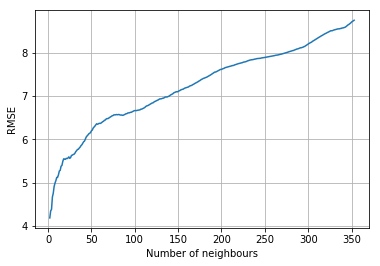

In [16]:
boston = datasets.load_boston()
boston_rmse = []
X = boston.data
y = boston.target

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scale the date
scale = MinMaxScaler()
X_train = scale.fit_transform(X_train)
X_test = scale.transform(X_test)

knn_boston_rmse = []
for k in range(2, len(X_train)):
    reg = KnnRegression(k)
    reg.fit(X_train, y_train)
    boston_pred = []
    boston_target_pred = reg.predict(X_test)
    boston_rmse.append(get_rmse(boston_target_pred, y_test))

plt.plot(range(2,len(X_train)), boston_rmse)
plt.xlabel('Number of neighbours')
plt.ylabel('RMSE')
plt.grid()
plt.show()

So above graph also tells us that lower k values are much better for our predictions compared to higher ones.

## Comparision of our implementation with Scikit Learn Package

In [17]:
m = KNeighborsRegressor(n_neighbors=2)
m.fit(X_train, y_train)
pred = m.predict(X_test)
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(y_test,pred))

4.187909445811333

In [18]:
reg = KnnRegression(2)
reg.fit(X_train, y_train)
pred = reg.predict(X_test)
get_rmse(y_test,pred)

4.1879

**We can see that our implementation predictions matches with the sklearn predictions.**

## Pro's and Con's of using kNN
### Pro's
1. Simple - easy to apply and interpret
2. No assumptions about distribution of data - useful for ill-tempered data
3. No training

### Con's
1. High memory requirement - stores all of the data
2. Computationally expensive - must compute all distances
3. Sensitive to irrelevant features and the feature scaling
4. Not very good for high dimensional data

## Time complexity and working with large data

Since the algorithm of kNN requires us to calculate the distance of the test point from each point in training, the time complexity is **linear i.e O(n)** and **computation time increases as number of training points increases**. So, it the data set is very large with lot of dimension, the algorithm becomes really slow. Let's see this problem through following code:

In [19]:
# import some data to play with
iris = datasets.load_iris()
X = iris.data
y = iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
n = X_train.shape[0]
k=5

def knn_time():
    clf = KnnClassifier(k)
    clf.fit(X_train, y_train)
    iris_target_pred = clf.predict(X_test)

print('Time elapsed (hh:mm:ss.ms) {} for {} number of data points in training'.format(timeit.timeit(knn_time,number=100), n))

Time elapsed (hh:mm:ss.ms) 0.26026112699992154 for 105 number of data points in training


In [20]:
X_train_large = np.array(list(X_train)*100)
y_train_large = np.array(list(y_train)*100)
n = X_train_large.shape[0]

In [21]:
def knn_time():
    clf = KnnClassifier(k)
    clf.fit(X_train_large, y_train_large)
    iris_target_pred = clf.predict(X_test)

print('Time elapsed (hh:mm:ss.ms) {} for {} number of data points in training'.format(timeit.timeit(knn_time,number=100), n))


Time elapsed (hh:mm:ss.ms) 6.6178982730002645 for 10500 number of data points in training


From above code we can see that the **prediction time increases as the size of the training data increases**. We donot observe a 100 time increase in time because there is some addition system time also in play along with model computation time. Nevertheless, it shows us that kNN is not a good choice if we have large training data and the major time is spent in prediction which is not desired. To overcome this issue we can use **ANN** algos. **ANN helps us reduce the probable data set on which we need to perform nearest neighbour search making the model complexity sublinear.**. We will discuss **ANN's** in a separate  notebook 

## Summary

If you wish to apply kNN in practice  proceed as follows:
1. Get labeled data set
2. Split in train-validation split
3. Preprocess the data (Normalize/Standardize)
4. Dimensionality reduction if required
5. Choose distance/similarity metric
6. Find k value by checking performance in validation set
7. Get test data to make prediction
8. Choose method of prediction (voting/Mean/Median/Weighted)
7. Fit the model and predict
8. Choose model performance metric 
